# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
img_dir = os.path.join("data", "images")
try:
    os.makedirs(img_dir)
except Exception:
    print("Something goes wrong.")
number_images = 30

Something goes wrong.


In [51]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(img_dir, f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imgname, frame)
    cv2.imshow("grame", frame)
    time.sleep(0.5)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

### Extra: Resize all images for the sake of consistency.

In [3]:
from PIL import Image
img_size = (640, 480)
for i in os.listdir(img_dir):
    im = Image.open(os.path.join(img_dir, i)).resize(img_size, Image.ANTIALIAS)
    save_dir = os.path.join("data", "images", i)
    im.save(save_dir)

<ipython-input-3-483909f0b5c1>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = Image.open(os.path.join(img_dir, i)).resize(img_size, Image.ANTIALIAS)


### 1.3 Annotate Images with LabelMe

In [5]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\soshi\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices("GPU")

[]

### 2.3 Load Image into TF Data Pipeline

In [9]:
images = tf.data.Dataset.list_files("data\\images\\*.jpg")

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\IMG_6768.jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[ 88,  88,  88],
        [ 39,  39,  39],
        [  0,   0,   0],
        ...,
        [119, 119, 119],
        [115, 115, 115],
        [115, 115, 115]],

       [[ 75,  75,  75],
        [ 27,  27,  27],
        [  0,   0,   0],
        ...,
        [121, 121, 121],
        [121, 121, 121],
        [123, 123, 123]],

       [[ 54,  54,  54],
        [ 12,  12,  12],
        [  2,   2,   2],
        ...,
        [114, 114, 114],
        [115, 115, 115],
        [121, 121, 121]],

       ...,

       [[109,  91,  81],
        [110,  92,  82],
        [111,  93,  83],
        ...,
        [ 21,  21,  21],
        [ 17,  17,  17],
        [ 15,  15,  15]],

       [[108,  90,  80],
        [109,  91,  81],
        [111,  93,  83],
        ...,
        [  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[109,  91,  81],
        [110,  92,  82],
        [112,  94,  84],
        ...,
        [  1,   1,   1],
        [  2,   2,   2],
        [  3,   3,   3]]

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

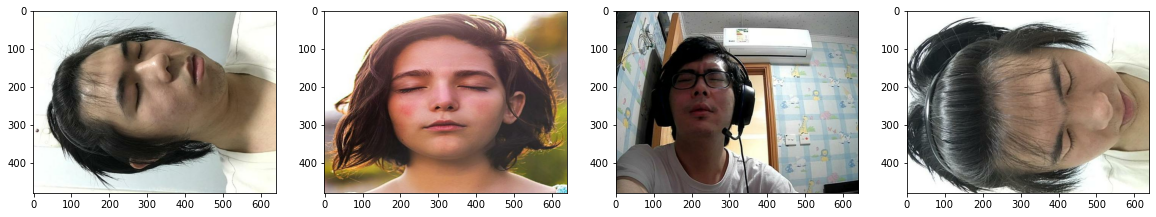

In [17]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [18]:
93*.7 # 65 to train

65.1

In [19]:
93*.15 # 14 and 14 to test and val

13.95

### 3.2 Move the Matching Labels

In [20]:
for folder in ["train", "test", "val"]:
    for file in os.listdir(os.path.join("data", folder, "images")):
        filename = file.split(".")[0] + ".json"
        existing_filepath = os.path.join("data", "labels", filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join("data", folder, "labels", filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [21]:
import albumentations as alb

In [22]:
augmentor = alb.Compose([alb.RandomCrop(width = 450, height = 450), 
                         alb.HorizontalFlip(p = 0.5), 
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RandomGamma(p = 0.2), 
                         alb.RGBShift(p = 0.2), 
                         alb.VerticalFlip(p = 0.5)], 
                        bbox_params=alb.BboxParams(format = "albumentations", 
                                                  label_fields = ["class_labels"]))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [24]:
img = cv2.imread(os.path.join("data", "train", "images", "4ea7de1e-d066-11ec-8aed-b42e99b6ed2f.jpg"))
img = cv2.resize(img, img_size)

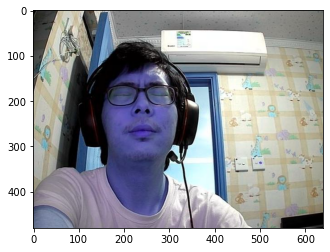

In [25]:
plt.imshow(img)

In [26]:
img.shape

(480, 640, 3)

In [27]:
with open(os.path.join("data", "train", "labels", "4ea7de1e-d066-11ec-8aed-b42e99b6ed2f.json"), "r") as f:
    label = json.load(f)

In [28]:
label["shapes"][0]["points"]

[[151.86721991701245, 99.18257261410788],
 [330.29045643153523, 331.9626556016597]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [29]:
coords = [0, 0, 0, 0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [30]:
coords

[151.86721991701245, 99.18257261410788, 330.29045643153523, 331.9626556016597]

In [31]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [32]:
coords

[0.23729253112033194,
 0.20663035961272475,
 0.5160788381742738,
 0.6915888658367911]

### 4.4 Apply Augmentations and View Results

In [33]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['close'])

In [34]:
augmented['bboxes'][0][2:]

(0.4850899031811894, 0.673250345781466)

In [35]:
augmented['bboxes']

[(0.08859382203780544,
  0.1559612724757953,
  0.4850899031811894,
  0.673250345781466)]

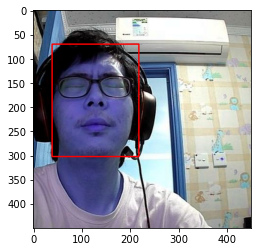

In [36]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [37]:
imgSize = (480, 640)

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        img = cv2.resize(img,imgSize)

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['close'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [38]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [39]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [41]:
train_images.as_numpy_iterator().next()

array([[[0.7147059 , 0.7730392 , 0.7352941 ],
        [0.6779412 , 0.721875  , 0.6874387 ],
        [0.65324754, 0.6924632 , 0.6542279 ],
        ...,
        [0.549326  , 0.5375613 , 0.5022672 ],
        [0.55655634, 0.54148287, 0.49803922],
        [0.5563725 , 0.54068625, 0.49454656]],

       [[0.7050858 , 0.7678309 , 0.72683823],
        [0.6778799 , 0.72493875, 0.6838848 ],
        [0.6514706 , 0.69417894, 0.6405637 ],
        ...,
        [0.5372549 , 0.525     , 0.4897059 ],
        [0.52892154, 0.5132353 , 0.46666667],
        [0.5480392 , 0.5323529 , 0.4852941 ]],

       [[0.69509804, 0.75784314, 0.7147059 ],
        [0.67015934, 0.72408086, 0.6726103 ],
        [0.6376838 , 0.68082106, 0.6181985 ],
        ...,
        [0.5357843 , 0.5240196 , 0.48872548],
        [0.5185662 , 0.5028799 , 0.4563113 ],
        [0.5348039 , 0.51911765, 0.47205883]],

       ...,

       [[0.77205884, 0.8112745 , 0.7681373 ],
        [0.763174  , 0.8102328 , 0.76415443],
        [0.7731005 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [43]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.09503, 0.0611 , 0.868  , 1.     ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [47]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3900, 3900, 840, 840, 840, 840)

### 7.2 Create Final Datasets (Images/Labels)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [49]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [50]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4644 , 0.0756 , 0.7417 , 0.676  ],
        [0.1547 , 0.04712, 0.8145 , 0.631  ],
        [0.1755 , 0.1426 , 0.838  , 0.8643 ],
        [0.1952 , 0.1001 , 0.4968 , 0.7593 ],
        [0.3    , 0.     , 0.821  , 0.6655 ],
        [0.5093 , 0.1964 , 0.807  , 0.886  ],
        [0.3145 , 0.     , 0.8506 , 0.5576 ],
        [0.2251 , 0.     , 0.925  , 0.4092 ]], dtype=float16))

### 7.3 View Images and Annotations

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


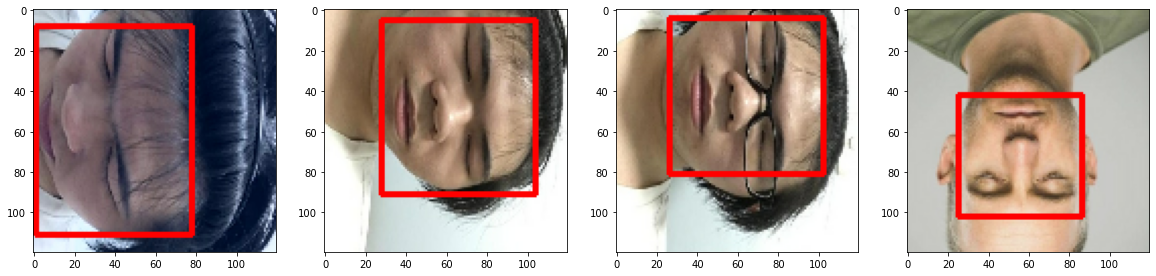

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [56]:
vgg = VGG16(include_top=False)

In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [58]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

In [61]:
X, y = train.as_numpy_iterator().next()

In [62]:
X.shape

(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

In [64]:
classes, coords

(array([[0.4077062 ],
        [0.36261076],
        [0.31156236],
        [0.3549313 ],
        [0.40580887],
        [0.33335218],
        [0.3677751 ],
        [0.4253171 ]], dtype=float32),
 array([[0.6834692 , 0.6498888 , 0.4188081 , 0.5532904 ],
        [0.7161832 , 0.57422733, 0.5075781 , 0.5205928 ],
        [0.78633344, 0.68051296, 0.28376427, 0.5423    ],
        [0.60195434, 0.64470184, 0.4799    , 0.6457554 ],
        [0.69437027, 0.6281536 , 0.4925571 , 0.57732385],
        [0.6579542 , 0.58610064, 0.46026564, 0.5956066 ],
        [0.6638577 , 0.57698476, 0.467331  , 0.6204667 ],
        [0.6953279 , 0.60743886, 0.4520786 , 0.58534676]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [65]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [66]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [67]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [68]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [69]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=13.71217>

In [70]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9961564>

In [71]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=13.71217>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [72]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [73]:
model = FaceTracker(facetracker)

In [74]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [75]:
logdir='logs'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [77]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
488/488 [==============================] - 422s 861ms/step - total_loss: 0.1685 - class_loss: 0.0062 - regress_loss: 0.1654 - val_total_loss: 0.2831 - val_class_loss: 3.0214e-05 - val_regress_loss: 0.2831
Epoch 2/10
488/488 [==============================] - 427s 872ms/step - total_loss: 0.0297 - class_loss: 6.6599e-06 - regress_loss: 0.0297 - val_total_loss: 0.0377 - val_class_loss: 2.2203e-06 - val_regress_loss: 0.0377
Epoch 3/10
488/488 [==============================] - 466s 953ms/step - total_loss: 0.0200 - class_loss: 1.8099e-06 - regress_loss: 0.0200 - val_total_loss: 0.1214 - val_class_loss: 2.1607e-07 - val_regress_loss: 0.1214
Epoch 4/10
488/488 [==============================] - 450s 920ms/step - total_loss: 0.0161 - class_loss: 1.0870e-06 - regress_loss: 0.0161 - val_total_loss: 0.2363 - val_class_loss: 1.1623e-06 - val_regress_loss: 0.2363
Epoch 5/10
488/488 [==============================] - 464s 949ms/step - total_loss: 0.0121 - class_loss: 4.1633e-07 - regres

### 10.3 Plot Performance

In [78]:
hist.history

{'total_loss': [0.007901658304035664,
  0.01688009686768055,
  0.009898713789880276,
  0.0039650266990065575,
  0.006925939116626978,
  0.004916428122669458,
  0.0014834762550890446,
  0.006739703938364983,
  0.002349387388676405,
  0.003371278988197446],
 'class_loss': [3.704617847688496e-05,
  2.3245904685609275e-06,
  4.470352337193617e-07,
  1.0877860177060938e-06,
  5.960465188081798e-08,
  1.1920930376163597e-07,
  3.2782565995148616e-07,
  4.0233155118585273e-07,
  1.7881400538044545e-07,
  0.0],
 'regress_loss': [0.007883135229349136,
  0.01687893457710743,
  0.009898490272462368,
  0.003964482806622982,
  0.00692590931430459,
  0.004916368518024683,
  0.0014833123423159122,
  0.006739502772688866,
  0.002349297981709242,
  0.003371278988197446],
 'val_total_loss': [0.28314951062202454,
  0.037665896117687225,
  0.1213797852396965,
  0.2362673431634903,
  0.2070482075214386,
  0.12688741087913513,
  0.23527465760707855,
  0.06665397435426712,
  0.20716722309589386,
  0.02520450

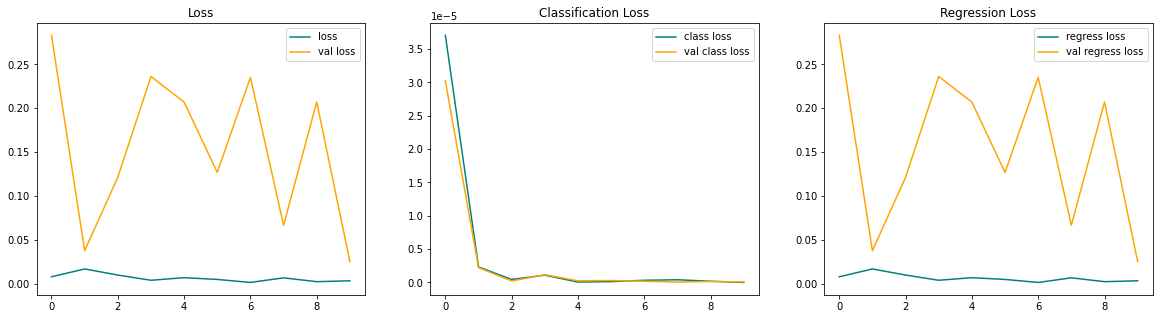

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [80]:
test_data = test.as_numpy_iterator()

In [81]:
test_sample = test_data.next()

In [82]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


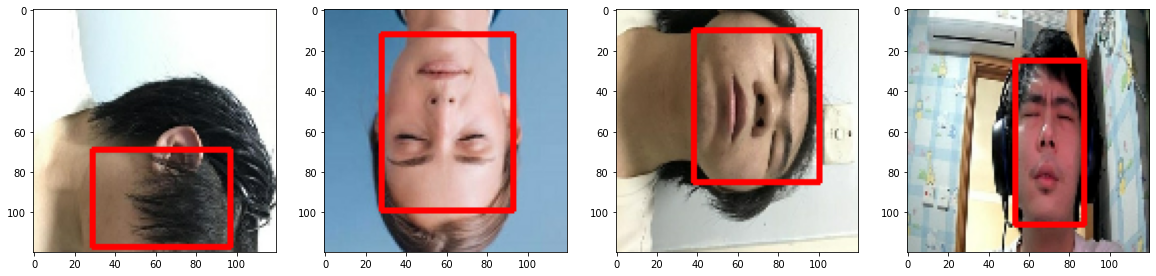

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [84]:
from tensorflow.keras.models import load_model

In [85]:
facetracker.save('facetracker.h5')

In [86]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [87]:
cap = cv2.VideoCapture(0)
#cap = cv2.VideoCapture('http://192.168.1.27:4747/mjpegfeed?640x480%27')
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [500,500]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [500,500]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,300]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,300]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'close', tuple(np.add(np.multiply(sample_coords[:2], [480,480]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()